In [1]:
!pip install eli5==0.13.0

# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
from shapely.geometry import Point
import geopandas as gpd
from geopandas.tools import sjoin
import pyproj
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import optuna
from sklearn.model_selection import train_test_split, KFold
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

from sklearn.inspection import permutation_importance
from matplotlib import rc

In [2]:
bus_path = 'data/bus_feature.csv'
subway_path  = 'data/subway_feature.csv'
dt_bus = pd.read_csv(bus_path)
dt_subway = pd.read_csv(subway_path)

In [3]:
train_path = 'data/train.csv'
test_path  = 'data/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [4]:
xy_path  = 'data/xy좌표.csv'
dt_xy = pd.read_csv(xy_path, encoding='cp949')

In [5]:
park_path = 'data/filtered_seoul_park.csv'
df_park = pd.read_csv(park_path, encoding = 'cp949')

In [6]:
# 기준 금리
base_rate = 'data/base_rate.xlsx'
dt_rate = pd.read_excel(base_rate, header=None)

In [7]:
#train + test
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test]) 
concat['is_test'].value_counts()

is_test
0    1118822
1       9272
Name: count, dtype: int64

In [8]:
# 시군구와 번지를 기준으로 concat과 dt_xy를 병합
merged_df = pd.merge(concat, dt_xy[['시군구', '번지', 'x', 'y']], how='left', on=['시군구', '번지'])

# 결측치 처리 함수
def handle_missing_values(df):
    # 좌표 X, Y 결측치 처리
    imputer = SimpleImputer(strategy='mean')
    df[['좌표X', '좌표Y']] = imputer.fit_transform(df[['좌표X', '좌표Y']])
    
    return df
    
concat = handle_missing_values(concat)

remaining_missing = concat[['좌표X', '좌표Y']].isnull().sum()
print(remaining_missing)

좌표X    0
좌표Y    0
dtype: int64


In [9]:
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

In [10]:
# 각 변수별 결측치 개수와 비율 계산
missing_values = concat.isnull().sum()
missing_percentage = (missing_values / len(concat)) * 100

missing_data = pd.DataFrame({
    '변수명': concat.columns,
    '결측치 개수': missing_values,
    '결측치 비율 (%)': missing_percentage
})

# 결측치 비율 내림차순
missing_data = missing_data.sort_values(by='결측치 비율 (%)', ascending=False).reset_index(drop=True)

print(missing_data)

                       변수명   결측치 개수  결측치 비율 (%)
0                 k-135㎡초과  1127765   99.970836
1                  해제사유발생일  1121899   99.450844
2                   k-등록일자  1116386   98.962143
3               단지소개기존clob  1058958   93.871433
4                   k-홈페이지  1013523   89.843843
5                 고용보험관리번호   920757   81.620592
6                 세대전기계약방법   885389   78.485392
7                   k-팩스번호   879348   77.949887
8                    k-시행사   877834   77.815678
9                  청소비관리형태   877751   77.808321
10              k-건설사(시공사)   877637   77.798215
11                 경비비관리형태   877561   77.791478
12      k-단지분류(아파트,주상복합등등)   877273   77.765949
13                  k-전체동수   877207   77.760098
14                   단지승인일   876854   77.728806
15                  k-전화번호   876850   77.728452
16                  k-복도유형   876454   77.693348
17                    건축면적   876279   77.677835
18                    주차대수   876277   77.677658
19           k-사용검사일-사용승인일   876259   77

In [13]:
# 'k-'로 시작하는 열
k_columns = [col for col in concat.columns if col.startswith('k-')]

# '결측치 비율 출력
missing_k_data = missing_data[missing_data['변수명'].isin(k_columns)]
print(missing_k_data)

# 'k-'로 시작하는 열 제거
concat = concat.drop(columns=k_columns)

print(f"제거된 변수: {k_columns}")
print(f"남은 변수 개수: {concat.shape[1]}")
print(concat.head())

                       변수명   결측치 개수  결측치 비율 (%)
0                 k-135㎡초과  1127765   99.970836
2                   k-등록일자  1116386   98.962143
4                   k-홈페이지  1013523   89.843843
7                   k-팩스번호   879348   77.949887
8                    k-시행사   877834   77.815678
10              k-건설사(시공사)   877637   77.798215
12      k-단지분류(아파트,주상복합등등)   877273   77.765949
13                  k-전체동수   877207   77.760098
15                  k-전화번호   876850   77.728452
16                  k-복도유형   876454   77.693348
19           k-사용검사일-사용승인일   876259   77.676062
21  k-전용면적별세대현황(60㎡~85㎡이하)   876170   77.668173
22      k-전용면적별세대현황(60㎡이하)   876170   77.668173
23                  k-수정일자   876170   77.668173
24                k-주거전용면적   876170   77.668173
25            k-85㎡~135㎡이하   876170   77.668173
26                   k-연면적   876125   77.664184
27               k-관리비부과면적   876125   77.664184
30                 k-전체세대수   876125   77.664184
31                  k-난방방식   876125   77

In [ ]:
# 필요없는 열 삭제
columns_to_remove = ['등기신청일자', '거래유형', '중개사소재지', 
                    '고용보험관리번호', '경비비관리형태', '세대전기계약방법', 
                     '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', 
                     '관리비 업로드', '단지신청일', '사용허가여부', '건축면적', '해제사유발생일', '단지소개기존clob', '주차대수']

concat= concat.drop(columns=columns_to_remove)

In [15]:
concat.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도',
       '도로명', '좌표X', '좌표Y', 'target', 'is_test'],
      dtype='object')

In [16]:
# 1. '시군구'에서 '서울특별시'를 제거하고 '구'와 '동'으로 나누기
concat['구'] = concat['시군구'].str.split(' ').str[1]  # '구' 부분 추출
concat['동'] = concat['시군구'].str.split(' ').str[2]  # '동' 부분 추출

# 2. '계약년월'에서 연도 추출 후 건축년도와의 차이를 계산하여 '구매당시 아파트 나이' 열 추가
concat['계약연도'] = concat['계약년월'].astype(str).str[:4].astype(int)  # 계약년월에서 연도만 추출
concat['아파트Age'] = concat['계약연도'] - concat['건축년도']  # 건축년도와의 차이 계산

concat.drop(columns=['시군구', '계약일'], inplace=True)

# 결과 확인
concat.head(10)

,번지,본번,부번,아파트명,전용면적,계약년월,층,건축년도,도로명,좌표X,좌표Y,target,is_test,구,동,계약연도,아파트Age
0,658-1,658.0,1.0,개포6차우성,79.97,201712,3,1987,언주로 3,127.05721,37.476763,124000.0,0,강남구,개포동,2017,30
1,658-1,658.0,1.0,개포6차우성,79.97,201712,4,1987,언주로 3,127.05721,37.476763,123500.0,0,강남구,개포동,2017,30
2,658-1,658.0,1.0,개포6차우성,54.98,201712,5,1987,언주로 3,127.05721,37.476763,91500.0,0,강남구,개포동,2017,30
3,658-1,658.0,1.0,개포6차우성,79.97,201801,4,1987,언주로 3,127.05721,37.476763,130000.0,0,강남구,개포동,2018,31
4,658-1,658.0,1.0,개포6차우성,79.97,201801,2,1987,언주로 3,127.05721,37.476763,117000.0,0,강남구,개포동,2018,31
5,658-1,658.0,1.0,개포6차우성,79.97,201801,1,1987,언주로 3,127.05721,37.476763,130000.0,0,강남구,개포동,2018,31
6,658-1,658.0,1.0,개포6차우성,79.97,201803,2,1987,언주로 3,127.05721,37.476763,139500.0,0,강남구,개포동,2018,31
7,658-1,658.0,1.0,개포6차우성,54.98,201804,5,1987,언주로 3,127.05721,37.476763,107500.0,0,강남구,개포동,2018,31
8,658-1,658.0,1.0,개포6차우성,79.97,201806,3,1987,언주로 3,127.05721,37.476763,145000.0,0,강남구,개포동,2018,31
9,658-1,658.0,1.0,개포6차우성,54.98,201807,3,1987,언주로 3,127.05721,37.476763,112000.0,0,강남구,개포동,2018,31


In [17]:
#30년
concat['30년 건축'] = concat['아파트Age'].apply(lambda x : 1 if x >= 30 else 0)

In [ ]:
"""
# 카카오 REST API 키 설정
api_key = 'ecbdc1f87b0d9ebabbb7d57424a9d771'

def get_coordinates(address):
    base_url = "https://dapi.kakao.com/v2/local/search/address.json"
    headers = {
        "Authorization": f"KakaoAK {api_key}"
    }
    params = {"query": address}

    try:
        response = requests.get(base_url, headers=headers, params=params)
        response.raise_for_status()
        data = response.json()
        if data['documents']:
            x = data['documents'][0]['x']
            y = data['documents'][0]['y']
            return x, y
        else:
            print(f"No coordinates found for address: {address}")
            return None, None
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err} - Address: {address}")
    except Exception as err:
        print(f"Other error occurred: {err} - Address: {address}")
    
    return None, None

# 전체 주소별 좌표 캐싱 딕셔너리 생성
address_coordinates = {}

def fill_only_missing_coordinates(df, address_column, x_col, y_col):
    """
    '좌표X'와 '좌표Y'가 결측치인 행들에 대해서만 좌표를 채우는 함수.
    """
    missing_df = df[(df[x_col].isna()) | (df[y_col].isna())].copy()  # 결측치가 있는 데이터만 복사
    
    for idx in tqdm(missing_df.index):
        address = df.loc[idx, address_column]
       
        if isinstance(address, str) and not pd.isna(address):
            # 전체 주소 사용
            full_address = address.strip()
           
            # 이미 저장된 좌표가 있는 경우 사용
            if full_address in address_coordinates:
                x, y = address_coordinates[full_address]
            else:
                # 새로 좌표를 받아오고 저장
                x, y = get_coordinates(full_address)
                time.sleep(1)  # API 호출 지연 추가
                if x is not None and y is not None:
                    address_coordinates[full_address] = (x, y)
                else:
                    # 좌표를 가져오지 못한 경우 로그 출력
                    print(f"Failed to get coordinates for address: {full_address}")
           
            # 좌표 업데이트
            if x is not None and y is not None:
                df.at[idx, x_col] = x
                df.at[idx, y_col] = y
        
# 결측치가 있는 행들만 처리
#fill_only_missing_coordinates(concat_select, address_column='시군구', x_col='좌표X', y_col='좌표Y')
"""

In [ ]:
"""
import json
import os

# 좌표 캐싱 결과 저장 경로
cache_file_path = 'address_coordinates_cache.json'

# 캐시 파일 로드 함수
def load_address_coordinates_cache():
    if os.path.exists(cache_file_path):
        with open(cache_file_path, 'r', encoding='utf-8') as f:
            return json.load(f)
    return {}

# 캐시 파일 저장 함수
def save_address_coordinates_cache(address_coordinates):
    with open(cache_file_path, 'w', encoding='utf-8') as f:
        json.dump(address_coordinates, f, ensure_ascii=False, indent=4)

# 캐시 파일 로드 - Step 1: API 호출 전에 캐시 파일 로드
address_coordinates = load_address_coordinates_cache()

# Step 2: 좌표 정보 업데이트 - API 호출이 필요한 경우에만 호출됨
fill_only_missing_coordinates(concat_select, address_column='시군구', x_col='좌표X', y_col='좌표Y')

# Step 3: 좌표 정보 업데이트 후 캐시 파일 저장
save_address_coordinates_cache(address_coordinates)
"""

In [18]:
#x,y 좌표 -> 버스 정류장, 지하철역

def preprocess_data(df, x_col, y_col):
    wgs84 = pyproj.CRS('EPSG:4326')  # WGS84 좌표계 (위도, 경도)
    utm_k = pyproj.CRS('EPSG:5179')  # UTM-K 좌표계 (한국)
    project = pyproj.Transformer.from_crs(wgs84, utm_k, always_xy=True).transform
    
    df['geometry'] = df.apply(lambda row: Point(project(row[x_col], row[y_col])), axis=1)
    return gpd.GeoDataFrame(df, geometry='geometry', crs=utm_k)

def calculate_density(gdf_real_estate, gdf_locations, radius):
    gdf_real_estate['buffer'] = gdf_real_estate.geometry.buffer(radius)
    
    joined = sjoin(gdf_locations, gdf_real_estate.set_geometry('buffer'), how='inner', predicate='within')
    
    density = joined.groupby(joined.index_right).size().rename('density')
    
    return gdf_real_estate.join(density, how='left').fillna(0)['density']

def process_in_chunks(df, locations_gdf, radius, chunk_size=10000):
    results = []
    for i in tqdm(range(0, len(df), chunk_size)):
        chunk = df.iloc[i:i+chunk_size]
        chunk_gdf = preprocess_data(chunk, '좌표X', '좌표Y')
        density = calculate_density(chunk_gdf, locations_gdf, radius)
        results.append(density)
    return pd.concat(results)

# 버스 정류장과 지하철역 데이터 전처리
bus_gdf = preprocess_data(dt_bus, 'X좌표', 'Y좌표')  # 버스 정류장 좌표계 변환

# 지하철 데이터는 위도, 경도 데이터를 X, Y로 변환
subway_gdf = preprocess_data(dt_subway, '경도', '위도')  # 지하철 데이터도 동일하게 좌표 변환

# 반경 설정
bus_radius = 500  # 미터 단위
subway_radius = 1000  # 1km를 미터 단위로 표현

# 청크 크기 설정
chunk_size = 10000

print("버스 정류장 밀도 계산 중 (500m 반경)...")
concat['bus_stop_density_500m'] = process_in_chunks(concat, bus_gdf, bus_radius, chunk_size)

print("지하철역 밀도 계산 중 (1km 반경)...")
concat['subway_station_density_1km'] = process_in_chunks(concat, subway_gdf, subway_radius, chunk_size)

# 결과 출력
print(concat[['좌표X', '좌표Y', 'bus_stop_density_500m', 'subway_station_density_1km']].head())

버스 정류장 밀도 계산 중 (500m 반경)...


100%|█████████████████████████████████████████| 113/113 [00:17<00:00,  6.60it/s]


지하철역 밀도 계산 중 (1km 반경)...


100%|█████████████████████████████████████████| 113/113 [00:15<00:00,  7.46it/s]

         좌표X        좌표Y  bus_stop_density_500m  subway_station_density_1km
0  127.05721  37.476763                     13                         0.0
1  127.05721  37.476763                     13                         0.0
2  127.05721  37.476763                     13                         0.0
3  127.05721  37.476763                     13                         0.0
4  127.05721  37.476763                     13                         0.0


In [19]:
# '구'의 평균 가격을 기준
gu_order = concat.groupby('구')['target'].mean().sort_values(ascending=False).index.tolist()
gu_mapping = {gu: label for label, gu in enumerate(gu_order)}

# '구'를 평균 가격 순위에 따라 인코딩
concat['new_구'] = concat['구'].map(gu_mapping)

In [20]:
# '동'의 평균 가격을 기준으로 순위를 매김
dong_order = concat.groupby('동')['target'].mean().sort_values(ascending=False).index.tolist()
dong_mapping = {dong: label for label, dong in enumerate(dong_order)}

# '동'을 평균 가격 순위에 따라 인코딩
concat['new_동'] = concat['동'].map(dong_mapping)

In [21]:
# '동'별 target의 표준편차 계산
dong_std_order = concat.groupby('동')['target'].std().sort_values(ascending=False).index.tolist()

# 표준편차를 기준으로 '동'을 순위 매김
dong_std_mapping = {dong: label for label, dong in enumerate(dong_std_order)}

# '동'을 표준편차 순위에 따라 인코딩
concat['동_std'] = concat['동'].map(dong_std_mapping)
print(concat[['동', '동_std']].head())

     동  동_std
0  개포동     27
1  개포동     27
2  개포동     27
3  개포동     27
4  개포동     27


In [22]:
# 'train_test' 열이 없다면 concat이 학습 데이터
train = concat.copy()

# 'target'의 NaN 값 처리 및 정수변환
train['target'] = train['target'].replace([np.inf, -np.inf], np.nan).fillna(0)
train['target'] = train['target'].astype('int')

# groupby, 아파트 평균 가격 배열 생성
data = train[['아파트명', 'target']].groupby('아파트명').mean()
arr = data['target'].to_numpy().reshape(-1, 1)

# cluster
k = 5
kmeans = KMeans(n_clusters=k, n_init=10)
kmeans.fit(arr)
sort_order = np.argsort(kmeans.cluster_centers_.flatten())

# 군집화 결과를 가격 순서대로 
labels = np.zeros_like(kmeans.labels_)
# 각 클러스터를 가격 순서대로
for i, cluster in enumerate(sort_order):
    labels = np.where(kmeans.labels_ == cluster, i, labels)

# 군집화 결과와 가격을 데이터에 추가
data['cluster'] = labels
data = data.reset_index()
data = data[['아파트명', 'cluster']]

# 원본 데이터프레임에 클러스터 정보 추가 (아파트명 기준 매핑)
concat['아파트명기준_cluster'] = concat['아파트명'].map(data.set_index('아파트명')['cluster'])

# NaN 값을 -1로 대체
concat['아파트명기준_cluster'] = concat['아파트명기준_cluster'].fillna(-1)

print(concat[['아파트명', '아파트명기준_cluster']].head())

     아파트명  아파트명기준_cluster
0  개포6차우성             1.0
1  개포6차우성             1.0
2  개포6차우성             1.0
3  개포6차우성             1.0
4  개포6차우성             1.0


In [ ]:
"""
from sklearn.ensemble import IsolationForest

# 아파트명기준_cluster 별로 이상치를 탐지하기 위한 함수 정의
def detect_outliers_with_isolation_forest(df, cluster_column, target_column):
    df['아파트명기준_이상치'] = 0  # 초기화

    for cluster in df[cluster_column].unique():
        # 해당 클러스터의 데이터 선택
        cluster_data = df[df[cluster_column] == cluster]
        
        if len(cluster_data) > 10:  # 충분한 데이터가 있는 경우에만 진행
            # Isolation Forest 모델 생성 및 학습
            iso_forest = IsolationForest(contamination=0.05, random_state=42)
            cluster_data['이상치여부'] = iso_forest.fit_predict(cluster_data[[target_column]])
            
            # 이상치로 판단된 행의 경우 1로 표시
            df.loc[cluster_data.index, '아파트명기준_이상치'] = cluster_data['이상치여부'].apply(lambda x: 1 if x == -1 else 0)

    return df

# 이상치 탐지 적용
concat = detect_outliers_with_isolation_forest(concat, '아파트명기준_cluster', 'target')

# 결과 확인
print(concat[['아파트명기준_cluster', 'target', '아파트명기준_이상치']].head(10))
"""

In [23]:
#금리
#첫 번째 행을 '날짜', 두 번째 행을 '기준금리'로 변환
dt_rate = pd.DataFrame({
    '날짜' : dt_rate.iloc[0, :].values, #세로로 변환
    '기준금리' : dt_rate.iloc[1, :].values
})

dt_rate.reset_index(drop=True, inplace=True)

print(dt_rate.head())

        날짜  기준금리
0  200701월  4.50
1  200702월  4.50
2  200703월  4.50
3  200704월  4.50
4  200705월  4.50


In [24]:
#날짜에서 '월' 지우기
dt_rate['날짜']=dt_rate['날짜'].str.replace('월','')

In [25]:
#데이터타입 일치시키기
dt_rate['날짜'] = dt_rate['날짜'].astype(int)
concat['계약년월'] = concat['계약년월'].astype(int)

# 병합 과정에서 누락되는 것을 방지하기 위해, 계약년월과 기준금리가 일치하는지 직접 확인하는 방식으로 병합
concat['기준금리'] = concat['계약년월'].map(dt_rate.set_index('날짜')['기준금리'])

#날짜 컬럼 제거
#concat.drop(columns='날짜', inplace=True)

#기준금리 데이터타입 변환
concat['기준금리']= concat['기준금리'].astype(float)

#결과 출력
print(concat.head(5))

# 결측치 확인
print(f"기준금리 결측치 수: {concat['기준금리'].isnull().sum()}")

      번지     본번   부번    아파트명   전용면적    계약년월  층  건축년도    도로명        좌표X  ...  \
0  658-1  658.0  1.0  개포6차우성  79.97  201712  3  1987  언주로 3  127.05721  ...   
1  658-1  658.0  1.0  개포6차우성  79.97  201712  4  1987  언주로 3  127.05721  ...   
2  658-1  658.0  1.0  개포6차우성  54.98  201712  5  1987  언주로 3  127.05721  ...   
3  658-1  658.0  1.0  개포6차우성  79.97  201801  4  1987  언주로 3  127.05721  ...   
4  658-1  658.0  1.0  개포6차우성  79.97  201801  2  1987  언주로 3  127.05721  ...   

   계약연도  아파트Age  30년 건축 bus_stop_density_500m subway_station_density_1km  \
0  2017      30       1                    13                        0.0   
1  2017      30       1                    13                        0.0   
2  2017      30       1                    13                        0.0   
3  2018      31       1                    13                        0.0   
4  2018      31       1                    13                        0.0   

   new_구  new_동  동_std  아파트명기준_cluster  기준금리  
0      0     47     2

In [26]:

#강남역기준 영향
def calculate_distance(lat1, lon1, lat2, lon2):
    # 거리 계산 함수(유클리드)
    return np.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2)

gangnam_center_lat, gangnam_center_lon = 37.4979, 127.0276  # 강남역

concat['강남_거리'] = calculate_distance(concat['좌표Y'], concat['좌표X'], gangnam_center_lat, gangnam_center_lon)


In [27]:

# 공원
from scipy.spatial import cKDTree
from pyproj import Transformer

def calculate_park_features_optimized(df_real_estate, df_park):
    # 좌표계 변환 설정 (WGS84에서 UTM-K로)
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:5179", always_xy=True)
    # 부동산 데이터 좌표 변환
    df_real_estate['x'], df_real_estate['y'] = transformer.transform(df_real_estate['좌표X'], df_real_estate['좌표Y'])
    # 공원 데이터 좌표 변환
    df_park['x'], df_park['y'] = transformer.transform(df_park['경도'], df_park['위도'])
    # 결측치 및 무한값 처리 - 삭제 대신 기본값 채우기
    df_real_estate['x'] = df_real_estate['x'].replace([np.inf, -np.inf], np.nan).fillna(0)
    df_real_estate['y'] = df_real_estate['y'].replace([np.inf, -np.inf], np.nan).fillna(0)
    df_park['x'] = df_park['x'].replace([np.inf, -np.inf], np.nan).fillna(0)
    df_park['y'] = df_park['y'].replace([np.inf, -np.inf], np.nan).fillna(0)
    # KDTree 생성
    tree = cKDTree(df_park[['x', 'y']])
    # 가장 가까운 공원 찾기
    distances, _ = tree.query(df_real_estate[['x', 'y']], k=1)
    # 500m 내의 공원 개수 계산
    counts = []
    for _, row in df_real_estate.iterrows():
        nearby_parks = tree.query_ball_point([row['x'], row['y']], r=500)
        counts.append(len(nearby_parks))
    # 결과를 데이터프레임에 추가
    df_real_estate['nearest_park_distance'] = distances
    df_real_estate['parks_within_500m'] = counts
    # 'x'와 'y' 컬럼 드롭
    df_real_estate = df_real_estate.drop(columns=['x', 'y'])
    return df_real_estate

# 함수 적용
concat_with_parks = calculate_park_features_optimized(concat, df_park)

# 결과 출력
concat = concat_with_parks

print(concat[['아파트명', 'nearest_park_distance', 'parks_within_500m']].head())


     아파트명  nearest_park_distance  parks_within_500m
0  개포6차우성              502.35744                  0
1  개포6차우성              502.35744                  0
2  개포6차우성              502.35744                  0
3  개포6차우성              502.35744                  0
4  개포6차우성              502.35744                  0


In [28]:
# 최근 3년간 전용면적 대비 거래량

concat['계약년월'] = pd.to_datetime(concat['계약년월'], format='%Y%m')

# 최근 3년 데이터를 필터링.
recent_3_years = concat[concat['계약년월'] >= pd.to_datetime('2021-01-01')]

# 최근 3년간 거래량
transaction_vol = recent_3_years.groupby('아파트명')['target'].count().reset_index()
transaction_vol.columns = ['아파트명', '거래량_최근3년']

# '아파트명'별 거래량 - dict
transaction_vol_dict = transaction_vol.set_index('아파트명')['거래량_최근3년'].to_dict()

# mapping
concat['거래량_최근3년'] = concat['아파트명'].map(transaction_vol_dict)

# '전용면적 대비 거래량 add 
concat['전용면적_대비_거래량'] = concat['거래량_최근3년'] / concat['전용면적']

print(concat[['아파트명', '전용면적_대비_거래량']].head(10))

     아파트명  전용면적_대비_거래량
0  개포6차우성     0.087533
1  개포6차우성     0.087533
2  개포6차우성     0.127319
3  개포6차우성     0.087533
4  개포6차우성     0.087533
5  개포6차우성     0.087533
6  개포6차우성     0.087533
7  개포6차우성     0.127319
8  개포6차우성     0.087533
9  개포6차우성     0.127319


In [29]:
# 계약년월을 datetime으로 변환
concat['계약년월'] = pd.to_datetime(concat['계약년월'], format='%Y%m')

# 최근 3년 데이터 필터링
recent_3_years = concat[concat['계약년월'] >= pd.to_datetime('2021-01-01')]

# 3. 거래량 표준편차 계산
transaction_std = recent_3_years.groupby('아파트명')['target'].std().fillna(0).to_dict()
concat['거래량_표준편차'] = concat['아파트명'].map(transaction_std)

# 결과 확인
print(concat[['아파트명', '거래량_표준편차']].head(10))


     아파트명      거래량_표준편차
0  개포6차우성  10403.753901
1  개포6차우성  10403.753901
2  개포6차우성  10403.753901
3  개포6차우성  10403.753901
4  개포6차우성  10403.753901
5  개포6차우성  10403.753901
6  개포6차우성  10403.753901
7  개포6차우성  10403.753901
8  개포6차우성  10403.753901
9  개포6차우성  10403.753901


In [30]:
concat['계약년월'] = pd.to_datetime(concat['계약년월'], format='%Y%m')

# 최근 3년 데이터 필터링 (2021-01-01 이후)
recent_3_years = concat[concat['계약년월'] >= pd.to_datetime('2021-01-01')]

# 아파트별로 첫번째 가격과 마지막 가격을 구합니다.
price_changes = recent_3_years.groupby('아파트명')['target'].agg(['first', 'last']).reset_index()
price_changes['가격변화율_최근3년'] = (price_changes['last'] - price_changes['first']) / price_changes['first']

# '아파트명'별 가격변화율 딕셔너리 생성
price_changes_dict = price_changes.set_index('아파트명')['가격변화율_최근3년'].to_dict()

# 원본 데이터에 가격 변화율 추가
concat['가격변화율_최근3년'] = concat['아파트명'].map(price_changes_dict)

# 결과 확인
print(concat[['아파트명', '가격변화율_최근3년']].head(10))

     아파트명  가격변화율_최근3년
0  개포6차우성    0.023256
1  개포6차우성    0.023256
2  개포6차우성    0.023256
3  개포6차우성    0.023256
4  개포6차우성    0.023256
5  개포6차우성    0.023256
6  개포6차우성    0.023256
7  개포6차우성    0.023256
8  개포6차우성    0.023256
9  개포6차우성    0.023256


In [31]:
concat['계약년월'] = pd.to_datetime(concat['계약년월'], format='%Y%m')

# 전용면적별 가격 변동성 계산
area_price_stats = concat.groupby('전용면적')['target'].agg(['mean', 'std']).reset_index()

# 전용면적 (std/mean)
area_price_stats['전용면적별_가격_변동성'] = area_price_stats['std'] / area_price_stats['mean']

area_price_stats = area_price_stats[['전용면적', '전용면적별_가격_변동성']]

#dict 
area_price_change_dict = area_price_stats.set_index('전용면적')['전용면적별_가격_변동성'].to_dict()

#map
concat['전용면적별_가격_변동성'] = concat['전용면적'].map(area_price_change_dict)

print(concat[['전용면적', '전용면적별_가격_변동성']].head(10))

    전용면적  전용면적별_가격_변동성
0  79.97      0.611489
1  79.97      0.611489
2  54.98      0.330867
3  79.97      0.611489
4  79.97      0.611489
5  79.97      0.611489
6  79.97      0.611489
7  54.98      0.330867
8  79.97      0.611489
9  54.98      0.330867


In [32]:
concat['계약년월'] = pd.to_datetime(concat['계약년월'], format='%Y%m')

# recent 3 years - 면적
recent_3_years = concat[concat['계약년월'] >= pd.to_datetime('2021-01-01')]

# 동별 전용면적의 종류 수를 계산하여 거래 다양성을 나타냄
dong_area_diversity = recent_3_years.groupby('new_동')['전용면적'].nunique().reset_index()
dong_area_diversity.columns = ['new_동', '동_전용면적_다양성']

# map
dong_area_diversity_dict = dong_area_diversity.set_index('new_동')['동_전용면적_다양성'].to_dict()
concat['동_전용면적_다양성'] = concat['new_동'].map(dong_area_diversity_dict)

print(concat[['new_동', '동_전용면적_다양성']].head(10))

   new_동  동_전용면적_다양성
0     47        96.0
1     47        96.0
2     47        96.0
3     47        96.0
4     47        96.0
5     47        96.0
6     47        96.0
7     47        96.0
8     47        96.0
9     47        96.0


In [33]:
#전용면적 59, 84 or over 
def area_define(area):
    if area < 60: # 59
        return 0
    elif area < 85: # 84
        return 1
    else:
        return 2

concat['area_type'] = concat['전용면적'].apply(area_define)
concat['area_type'].value_counts()

area_type
1    482741
0    445930
2    199423
Name: count, dtype: int64

In [34]:
concat.drop(columns=['건축년도'], inplace=True)
concat = concat.drop(columns=['좌표X', '좌표Y'])

In [35]:
concat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1128094 entries, 0 to 9271
Data columns (total 32 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   번지                          1127867 non-null  object        
 1   본번                          1128019 non-null  float64       
 2   부번                          1128019 non-null  float64       
 3   아파트명                        1125958 non-null  object        
 4   전용면적                        1128094 non-null  float64       
 5   계약년월                        1128094 non-null  datetime64[ns]
 6   층                           1128094 non-null  int64         
 7   도로명                         1128094 non-null  object        
 8   target                      1118822 non-null  float64       
 9   is_test                     1128094 non-null  int64         
 10  구                           1128094 non-null  object        
 11  동                           1128

In [36]:
continuous_columns = []
categorical_columns = []

for column in concat.columns:
    if pd.api.types.is_numeric_dtype(concat[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['본번', '부번', '전용면적', '층', 'target', 'is_test', '계약연도', '아파트Age', '30년 건축', 'bus_stop_density_500m', 'subway_station_density_1km', 'new_구', 'new_동', '동_std', '아파트명기준_cluster', '기준금리', '강남_거리', 'nearest_park_distance', 'parks_within_500m', '거래량_최근3년', '전용면적_대비_거래량', '거래량_표준편차', '가격변화율_최근3년', '전용면적별_가격_변동성', '동_전용면적_다양성', 'area_type']
범주형 변수: ['번지', '아파트명', '계약년월', '도로명', '구', '동']


In [37]:
#categorical - null
concat[categorical_columns] = concat[categorical_columns].fillna('NULL')

#continuous - linear
concat[continuous_columns] = concat[continuous_columns].interpolate(method='linear', axis=0)

In [38]:
concat.isnull().sum() 

번지                            0
본번                            0
부번                            0
아파트명                          0
전용면적                          0
계약년월                          0
층                             0
도로명                           0
target                        0
is_test                       0
구                             0
동                             0
계약연도                          0
아파트Age                        0
30년 건축                        0
bus_stop_density_500m         0
subway_station_density_1km    0
new_구                         0
new_동                         0
동_std                         0
아파트명기준_cluster                0
기준금리                          0
강남_거리                         0
nearest_park_distance         0
parks_within_500m             0
거래량_최근3년                      0
전용면적_대비_거래량                   0
거래량_표준편차                      0
가격변화율_최근3년                    0
전용면적별_가격_변동성                  0
동_전용면적_다양성                    0
area_typ

       구        평균 실거래가
0    강남구  114011.706572
1    강동구   54053.477165
2    강북구   38044.077291
3    강서구   44016.379842
4    관악구   41735.543498
5    광진구   66717.460498
6    구로구   38439.281979
7    금천구   33551.694397
8    노원구   33739.071437
9    도봉구   31818.652444
10  동대문구   44895.787936
11   동작구   60516.378080
12   마포구   63914.582161
13  서대문구   48655.021039
14   서초구  112808.452748
15   성동구   68263.246416
16   성북구   44847.382383
17   송파구   83242.901496
18   양천구   58651.847119
19  영등포구   55729.842714
20   용산구  105290.261774
21   은평구   43421.419900
22   종로구   57272.552700
23    중구   61558.171198
24   중랑구   35072.805833


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.


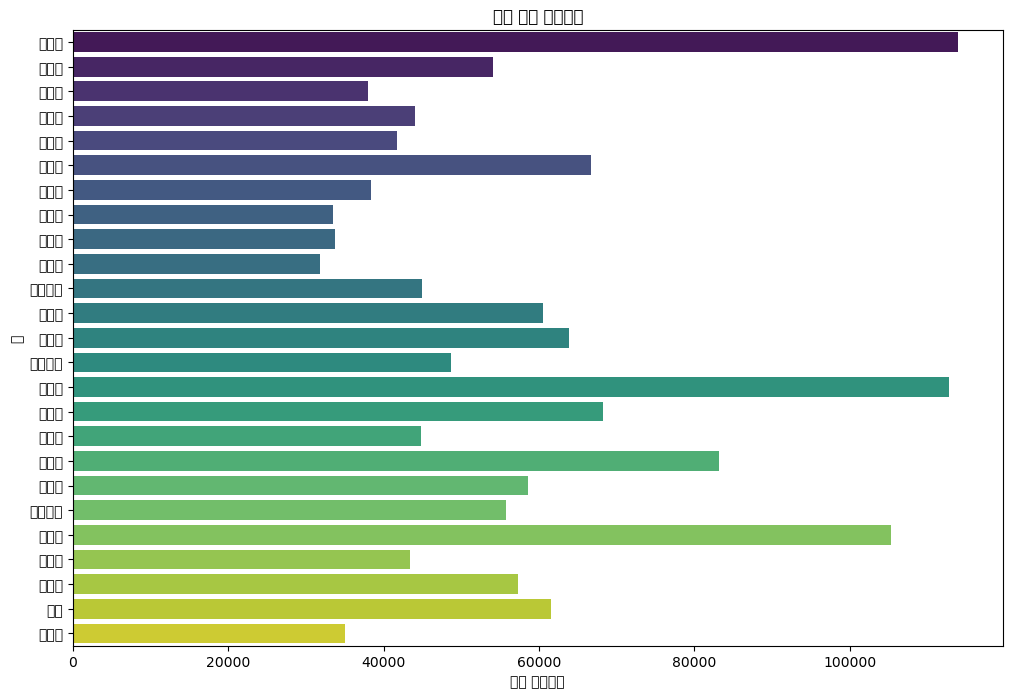

In [39]:
average_price_by_gu = concat.groupby('구')['target'].mean().reset_index()

average_price_by_gu.columns = ['구', '평균 실거래가']

# 결과 출력
print(average_price_by_gu)

plt.figure(figsize=(12, 8))
sns.barplot(data=average_price_by_gu, x='평균 실거래가', y='구', palette='viridis')
plt.title('구별 평균 실거래가')
plt.xlabel('평균 실거래가')
plt.ylabel('구')
plt.show()

In [40]:
#major Gu
all = list(concat['구'].unique())
majorGu = ['용산구','서초구', '강남구', '송파구', '성동구']
notMajorGu = [x for x in all if x not in majorGu]

assert len(all) == len(majorGu) + len(notMajorGu)

In [41]:
is_majorGu = [] 

for x in concat['구'].tolist():
    if x in majorGu:
        is_majorGu.append(1)
    else:
        is_majorGu.append(0)

concat['비싼 구'] = is_majorGu

print(concat[['구', '비싼 구']].head())


     구  비싼 구
0  강남구     1
1  강남구     1
2  강남구     1
3  강남구     1
4  강남구     1


In [42]:
# train과 test dataset을 분할
dt_train = concat.query('is_test==0')
dt_test = concat.query('is_test==1')

# is_test drop
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1118822, 32) (9272, 32)


In [43]:
dt_test.head(5)

,번지,본번,부번,아파트명,전용면적,계약년월,층,도로명,target,구,...,nearest_park_distance,parks_within_500m,거래량_최근3년,전용면적_대비_거래량,거래량_표준편차,가격변화율_최근3년,전용면적별_가격_변동성,동_전용면적_다양성,area_type,비싼 구
0,658-1,658.0,1.0,개포6차우성,79.9700,2023-07-01,5,언주로 3,13250.0,강남구,...,502.357440,0,7.0,0.087533,10403.753901,0.023256,0.611489,96.0,1,1
1,651-1,651.0,1.0,개포더샵트리에,108.2017,2023-08-01,10,개포로 311,13250.0,강남구,...,233.713919,5,1.0,0.009242,0.000000,0.000000,0.470854,96.0,2,1
2,652,652.0,0.0,개포우성3차,161.0000,2023-07-01,15,개포로 307,13250.0,강남구,...,247.778292,3,11.0,0.068323,66709.376471,0.134091,0.330220,96.0,2,1
3,652,652.0,0.0,개포우성3차,133.4600,2023-08-01,14,개포로 307,13250.0,강남구,...,247.778292,3,11.0,0.082422,66709.376471,0.134091,0.307676,96.0,2,1
4,652,652.0,0.0,개포우성3차,104.4300,2023-08-01,6,개포로 307,13250.0,강남구,...,247.778292,3,11.0,0.105334,66709.376471,0.134091,0.427528,96.0,2,1


In [44]:
dt_test['target'] = 0

In [45]:
#파생변수들 추가
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['본번', '부번', '전용면적', '층', 'target', '계약연도', '아파트Age', '30년 건축', 'bus_stop_density_500m', 'subway_station_density_1km', 'new_구', 'new_동', '동_std', '아파트명기준_cluster', '기준금리', '강남_거리', 'nearest_park_distance', 'parks_within_500m', '거래량_최근3년', '전용면적_대비_거래량', '거래량_표준편차', '가격변화율_최근3년', '전용면적별_가격_변동성', '동_전용면적_다양성', 'area_type', '비싼 구']
범주형 변수: ['번지', '아파트명', '계약년월', '도로명', '구', '동']


In [46]:
label_encoders = {}

# Implement Label Encoding
for col in tqdm(categorical_columns_v2):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit(dt_train[col].astype(str))
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl  # 나중에 후처리를 위해 레이블 인코더를 저장

    # Test 데이터에 대해 Label Encoding 적용
    # 새로운 라벨이 존재할 경우 예외 처리
    dt_test[col] = dt_test[col].astype(str)  # Ensure test data is also string
    unseen_labels = set(dt_test[col].unique()) - set(lbl.classes_)

    if unseen_labels:
        # 새로운 라벨을 인코더에 추가
        lbl.classes_ = np.append(lbl.classes_, list(unseen_labels))

    # Test 데이터 변환
    dt_test[col] = lbl.transform(dt_test[col])

# 결과 출력 확인
print(dt_train.head())
print(dt_test.head())


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.85it/s]

     번지     본번   부번  아파트명   전용면적  계약년월  층   도로명    target  구  ...  \
0  4732  658.0  1.0   328  79.97   131  3  6176  124000.0  0  ...   
1  4732  658.0  1.0   328  79.97   131  4  6176  123500.0  0  ...   
2  4732  658.0  1.0   328  54.98   131  5  6176   91500.0  0  ...   
3  4732  658.0  1.0   328  79.97   132  4  6176  130000.0  0  ...   
4  4732  658.0  1.0   328  79.97   132  2  6176  117000.0  0  ...   

   nearest_park_distance  parks_within_500m  거래량_최근3년  전용면적_대비_거래량  \
0              502.35744                  0       7.0     0.087533   
1              502.35744                  0       7.0     0.087533   
2              502.35744                  0       7.0     0.127319   
3              502.35744                  0       7.0     0.087533   
4              502.35744                  0       7.0     0.087533   

       거래량_표준편차  가격변화율_최근3년  전용면적별_가격_변동성  동_전용면적_다양성  area_type  비싼 구  
0  10403.753901    0.023256      0.611489        96.0          1     1  
1  10403.753901   

In [47]:
dt_train.head(1)  

,번지,본번,부번,아파트명,전용면적,계약년월,층,도로명,target,구,...,nearest_park_distance,parks_within_500m,거래량_최근3년,전용면적_대비_거래량,거래량_표준편차,가격변화율_최근3년,전용면적별_가격_변동성,동_전용면적_다양성,area_type,비싼 구
0,4732,658.0,1.0,328,79.97,131,3,6176,124000.0,0,...,502.35744,0,7.0,0.087533,10403.753901,0.023256,0.611489,96.0,1,1


In [48]:
# 같음
assert dt_train.shape[1] == dt_test.shape[1]

In [49]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

In [50]:
#xgbost
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'reg_alpha': trial.suggest_float('reg_alpha', 2, 8),  # L1 Regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 2, 8),  # L2 Regularization
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.8),
        'random_state': 2023
    }

    # K-Fold Cross-Validation < 교차검증 > 
    rmse_scores = []
    for train_index, val_index in kf.split(X_train):
        X_tr, X_va = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_va = y_train.iloc[train_index], y_train.iloc[val_index]

        # 모델 학습 및 검증
        model = XGBRegressor(**params)
        model.fit(X_tr, y_tr, 
                  eval_set=[(X_va, y_va)], 
                  verbose=False)

        y_pred = model.predict(X_va)
        rmse = np.sqrt(mean_squared_error(y_va, y_pred))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

In [51]:
# K-Fold Cross-Validation 설정
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=2023)

In [ ]:
#xgboost test - 길어져서 생략 <best parameter 찾는 과정: 이전에 찾았던 parameter>
# Optuna Study 생성 및 최적화
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  # 최적화 시도 횟수

# 최적의 하이퍼파라미터 출력
print(f"Best Parameters: {study.best_params}")

# 최적의 하이퍼파라미터
best_params = study.best_params
best_model = XGBRegressor(**best_params, random_state=2023)
best_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)

# 검증 데이터로 예측 수행
pred = best_model.predict(X_val)

# RMSE 계산
rmse_xgb = np.sqrt(mean_squared_error(y_val, pred))
print(f'Optimized XGBoost RMSE: {rmse_xgb:.4f}')

In [52]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

# XGBRegressor < based on the best parameter
model = XGBRegressor(
    n_estimators=932,  # 트리 개수 
    max_depth=8,       # 트리 깊이 
    learning_rate=0.10833887166665858, # 학습률 
    reg_alpha=5.151876694714292,
    reg_lambda=4.958195311945955,
    subsample=0.8602914870426506,
    colsample_bytree=0.7930490565977587,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)
pred = model.predict(X_val)

[0]	validation_0-rmse:42312.73832
[1]	validation_0-rmse:38430.13153
[2]	validation_0-rmse:35009.03315
[3]	validation_0-rmse:32119.57649
[4]	validation_0-rmse:29483.98344
[5]	validation_0-rmse:27102.28305
[6]	validation_0-rmse:24925.52928
[7]	validation_0-rmse:23027.43528
[8]	validation_0-rmse:21372.68396
[9]	validation_0-rmse:19994.61614
[10]	validation_0-rmse:18735.35883
[11]	validation_0-rmse:17600.92855
[12]	validation_0-rmse:16581.70167
[13]	validation_0-rmse:15723.99053
[14]	validation_0-rmse:14977.97778
[15]	validation_0-rmse:14312.86125
[16]	validation_0-rmse:13756.24869
[17]	validation_0-rmse:13262.62791
[18]	validation_0-rmse:12803.67026
[19]	validation_0-rmse:12408.32971
[20]	validation_0-rmse:12057.44903
[21]	validation_0-rmse:11724.04927
[22]	validation_0-rmse:11452.39916
[23]	validation_0-rmse:11196.28019
[24]	validation_0-rmse:10981.78077
[25]	validation_0-rmse:10794.78949
[26]	validation_0-rmse:10619.49441
[27]	validation_0-rmse:10454.65122
[28]	validation_0-rmse:10290.8

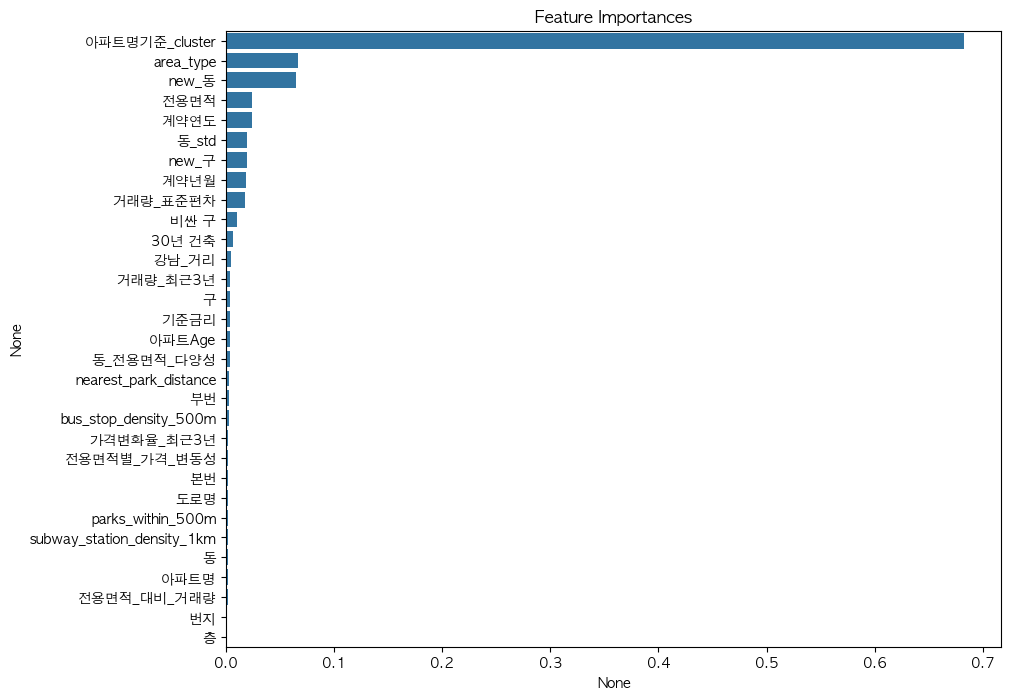

In [53]:
# 위 feature importance
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

rc('font', family='AppleGothic') 			
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10,8))
plt.title("Feature Importances")

sns.barplot(x=importances, y=importances.index)
plt.show()

In [54]:
# Validation dataset에 target과 pred 값 채워줌
X_val['target'] = y_val  # 실제 검증 데이터의 타겟값

# 'target' 컬럼 제거 후 예측 수행
X_val_no_target = X_val.drop(columns=['target'])

# 모델로 예측값 생성
X_val['pred'] = model.predict(X_val_no_target)

# Squared_error를 계산하는 함수를 정의합니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# Squared_error 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

# RMSE 계산
rmse = np.sqrt(squared_errors.mean())

# RMSE 출력
print(f"xgBoost RMSE: {rmse:.4f}")


xgBoost RMSE: 5505.1621


In [55]:
# 학습된 모델을 저장 / Pickle 라이브러리
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [56]:
dt_test.head(2)

,번지,본번,부번,아파트명,전용면적,계약년월,층,도로명,target,구,...,nearest_park_distance,parks_within_500m,거래량_최근3년,전용면적_대비_거래량,거래량_표준편차,가격변화율_최근3년,전용면적별_가격_변동성,동_전용면적_다양성,area_type,비싼 구
0,4732,658.0,1.0,328,79.9700,199,5,6176,0,0,...,502.357440,0,7.0,0.087533,10403.753901,0.023256,0.611489,96.0,1,1
1,4707,651.0,1.0,329,108.2017,198,10,469,0,0,...,233.713919,5,1.0,0.009242,0.000000,0.000000,0.470854,96.0,2,1


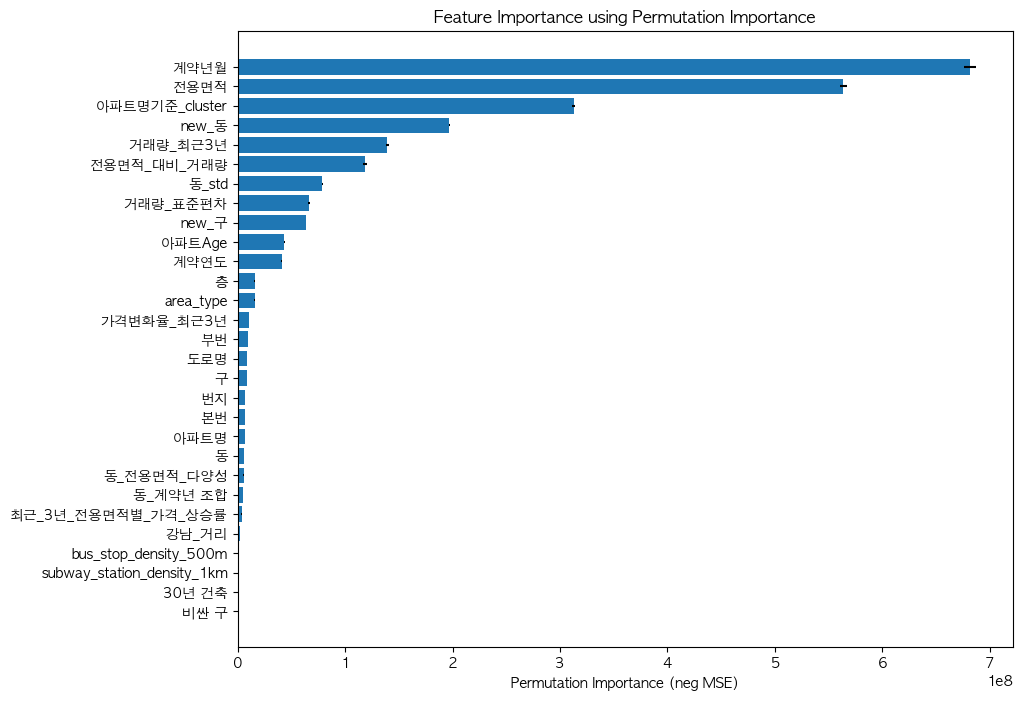

In [50]:
# 검증 데이터에서 예측 결과 관련 열 제거
X_val_clean = X_val.drop(columns=['target', 'pred', 'error'], errors='ignore')

# Permutation importance 계산
result = permutation_importance(
    model,  
    X_val_clean,          # 검증 데이터에서 불필요한 열을 제거한 데이터프레임
    y_val,                # 검증 데이터의 타겟 값
    n_repeats=10,         # 반복 수를 설정하여 더 안정적인 결과를 얻음
    random_state=42,
    scoring='neg_mean_squared_error'  # 회귀 문제에 적합한 평가 지표 사용
)

# 결과를 정렬하여 시각화
sorted_idx = result.importances_mean.argsort()

# 시각화
plt.figure(figsize=(10, 8))
rc('font', family='AppleGothic') 			
plt.rcParams['axes.unicode_minus'] = False
plt.barh(X_val_clean.columns[sorted_idx], result.importances_mean[sorted_idx], xerr=result.importances_std[sorted_idx])
plt.xlabel("Permutation Importance (neg MSE)")
plt.title("Feature Importance using Permutation Importance")
plt.show()

In [57]:
# Error가 큰 순서대로 sorting
X_val_sort = X_val.sort_values(by='error', ascending=False)  

X_val_sort_top100 = X_val_sort.head(100)  
X_val_sort_tail100 = X_val_sort.tail(100) 


In [58]:
# 해석을 위해 레이블 인코딩된 변수를 복원
error_top100 = X_val_sort_top100.copy()
best_top100 = X_val_sort_tail100.copy()

for column in categorical_columns_v2:
    if column in label_encoders:  # 인코더가 있는 경우에만 변환
        error_top100[column] = label_encoders[column].inverse_transform(error_top100[column])
        best_top100[column] = label_encoders[column].inverse_transform(best_top100[column])

In [59]:
display(error_top100.head(5))

,번지,본번,부번,아파트명,전용면적,계약년월,층,도로명,구,동,...,전용면적_대비_거래량,거래량_표준편차,가격변화율_최근3년,전용면적별_가격_변동성,동_전용면적_다양성,area_type,비싼 구,target,pred,error
224567,129,129.0,0.0,PH129,273.960,2022-04-01,16,압구정로79길 88,강남구,청담동,...,0.014601,230977.847910,0.076345,0.203996,120.0,2,1,1450000.0,1.025282e+06,1.803853e+11
221950,386,386.0,0.0,르가든더메인한남,227.370,2023-06-01,2,한남대로10길 16,용산구,한남동,...,0.026389,267738.989814,1.086022,0.106270,112.0,2,1,465000.0,8.135439e+05,1.214828e+11
241238,129,129.0,0.0,PH129,273.960,2021-03-01,14,압구정로79길 88,강남구,청담동,...,0.014601,230977.847910,0.076345,0.203996,120.0,2,1,1150000.0,8.218692e+05,1.076698e+11
221960,26-5,26.0,5.0,트윈빌에이동,170.680,2023-05-01,1,유엔빌리지길 11,용산구,한남동,...,0.017577,110151.410946,-0.400000,0.209453,112.0,2,1,250000.0,5.146736e+05,7.005209e+10
138889,467-29,467.0,29.0,타워팰리스3,214.967,2009-05-01,66,언주로30길 26,강남구,도곡동,...,0.130253,91093.095296,0.591549,0.234094,172.0,2,1,450000.0,1.866044e+05,6.937726e+10


In [60]:
# 저장된 모델을 불러옴
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [61]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference
real_test_pred = model.predict(X_test)

CPU times: user 350 ms, sys: 30.4 ms, total: 381 ms
Wall time: 59 ms


In [62]:
real_test_pred

array([200866.05, 243908.36, 339609.03, ...,  82610.67,  72725.19,
        72784.07], dtype=float32)

In [63]:
max_value = np.max(real_test_pred)

print("가장 큰 값:", max_value)

가장 큰 값: 1245312.1


In [64]:
# 앞서 예측한 예측값들을 저장
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output1.csv', index=False)